In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# De scikit-learn...

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

# Estandarización y modelado
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_selector
# Division de los datos
from sklearn.model_selection import train_test_split

# Normalización
from sklearn.preprocessing import MinMaxScaler

# Regresiones
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV, LogisticRegression

# ML metricas
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix

from setuptools import setup
from distutils.core import setup
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
import optuna
from optuna.trial import Trial

In [3]:
path= './weatherAUS.csv'
df = pd.read_csv(path, usecols=range(1,25))
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [4]:
### Busco duplicados
if not df.duplicated().any():
  print('No hay registros duplicados')

No hay registros duplicados


In [5]:
class ColDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    return X.drop(['Date'], axis=1)

In [6]:
class LocDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    costa_este = [' Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' ]
    X.loc[X['Location'].isin(costa_este), 'Location'] = 'costa_este'
    return X[X['Location'] == 'costa_este']

In [7]:
class CatFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X['WindGustDir'] = X.groupby('Location')['WindGustDir'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir9am'] = X.groupby('Location')['WindDir9am'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir3pm'] = X.groupby('Location')['WindDir3pm'].transform(lambda x: x.fillna(x.mode()[0]))

      return X

In [8]:
class NumFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      remanining_vnul_columns = X.columns[X.isna().any()].tolist()
      for col in remanining_vnul_columns:
        X[col] =  X[col].fillna(X[col].mean())

      return X

In [9]:
# https://www.mdpi.com/2078-2489/13/4/163 Como las variables de la dirección de los vientos pueden tener hasta 16 direcciones diferentes, para convertirlos a variables numéricas, se tiene encuenta una distribución circular. Por eso, cada una de las variables se dividió en dos: Una con el seno y otra con el coseno del angulo
class CoordRecat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        coord = {
            'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
            'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
            'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
            'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5,
        }

        # Aplicar la recategorización
        for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
            X[col] = X[col].map(coord)
            X[f'{col}_rad'] = np.deg2rad(X[col])
            X[f'{col}_sin'] = np.sin(X[f'{col}_rad']).round(5)
            X[f'{col}_cos'] = np.cos(X[f'{col}_rad']).round(5)

        # Eliminar columnas originales y columnas radianes
        columns_to_drop = [f'{col}_rad' for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']] + ['WindGustDir', 'WindDir9am', 'WindDir3pm']
        X = X.drop(columns=columns_to_drop, axis=1)

        return X

In [10]:
class LocEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      dummies = pd.get_dummies(X['Location'], dtype=int)
      X = pd.concat([X, dummies], axis=1)
      X.drop('Location', axis=1, inplace=True)

      return X

In [11]:
class ResetIndex(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reset_index(drop=True)

In [12]:
class BoolYNDropperEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X.dropna(subset=['RainToday'], inplace=True)
      X['RainTomorrow'] = X['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(float)
      X['RainToday'] = X['RainToday'].map({'No': 0, 'Yes': 1}).astype(float)

      return X

In [13]:
class Standarizer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    # Exclusión de variables booleanas y RainfallTmorrow porque no serán estandarizaradas
    exc_c = ['RainToday', 'RainTomorrow']#, ,'Canberra','Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

    # Estandarización
    df_sub = X[[col for col in X.columns if col not in exc_c]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_sub)

    X_scaled = pd.DataFrame(X_scaled, columns=df_sub.columns)
    for col in exc_c:
      X_scaled[f'{col}'] = X[col]

    # Nuevo DataFrame estandarizado con los nombres de las columnas originales
    return X_scaled

In [14]:
class OutliersTreater(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    cols_with_ouliers=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']

    for col in cols_with_ouliers:
      IQR=X[col].quantile(0.75)-X[col].quantile(0.25)
      lower_bridge=X[col].quantile(0.25)-(IQR*1.5)
      upper_bridge=X[col].quantile(0.75)+(IQR*1.5)

      X.loc[X[col]>=round(upper_bridge,2),col]=round(upper_bridge,2)
      X.loc[X[col]<=round(lower_bridge,2),col]=round(lower_bridge,2)

    return X


In [15]:
class RLValDropper(BaseEstimator, TransformerMixin):
  def fit (self, X, y=None):
    return self
  def transform(self, X):
    X.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)
    return X


In [16]:
preprocessor = Pipeline([
     ('drop_null_val_rl', RLValDropper()),
     ('drop_not_needed_features', ColDropper()),
     ('drop_nor_needed_locations',LocDropper()),
     ('yes_no_dropper_encoder', BoolYNDropperEncoder()),
     ('fill_null_cat', CatFiller()),
     ('fill_num_cat', NumFiller()),
     ('encode_loc', LocEncoder()),
     ('encode_wind_dir', CoordRecat()),
     ('reset_index',ResetIndex()),
     ('treat_outliers',OutliersTreater()),
     ('standariza_values', Standarizer())
])


# Train-Test split

In [17]:
# Separación de variables explicativas y variables objetivo
X = df.drop(['RainfallTomorrow'], axis=1).copy()
y = df[['RainfallTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((116329, 23), (29083, 23), (116329, 1), (29083, 1))

In [18]:
# Creo un Dataframe de TRAIN
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainfallTomorrow'] = y['RainfallTomorrow']

In [19]:
# Creo un Dataframe de TEST
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainfallTomorrow'] = y['RainfallTomorrow']

In [20]:
# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

In [21]:
X_train_regresion = df_train.iloc[:, :-1]
y_train_regresion = df_train.iloc[:,-1]

In [22]:
X_test_regresion = df_test.iloc[:, :-1]
y_test_regresion = df_test.iloc[:,-1]

In [23]:
def objective_reg(trial: Trial):
    # Create the model
    model = Sequential()

    # Define hyperparameters to optimize
    num_layers = trial.suggest_int('num_layers', 1, 5)
    num_units_input = trial.suggest_int('n_units_input', 4, 128)
    model.add(Dense(num_units_input, activation='relu', input_shape=(X_train_regresion.shape[1],)))

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128)
        model.add(Dense(num_units, activation='relu'))
        dropout_rate = trial.suggest_float(f'dropout_rate_layer_{i}', 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear'))  # Output layer for regression

    # Compile the model
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Split the data into training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_regresion, y_train_regresion, test_size=0.2, random_state=42)

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=64, verbose=0)

    # Evaluate the model
    score = model.evaluate(X_valid, y_valid, verbose=0)
    return score

In [24]:

# Run the Optuna optimization with a limited number of trials for a mockup run
study = optuna.create_study(direction='minimize')  # Minimize the loss
study.optimize(objective_reg, n_trials=10)

[I 2024-06-06 18:47:11,127] A new study created in memory with name: no-name-1c82dea8-99da-4431-b7d0-aced6ef177f4
[I 2024-06-06 18:47:15,362] Trial 0 finished with value: 0.12751232087612152 and parameters: {'num_layers': 4, 'n_units_input': 63, 'n_units_layer_0': 81, 'dropout_rate_layer_0': 0.4571478806739348, 'n_units_layer_1': 43, 'dropout_rate_layer_1': 0.4462564856579744, 'n_units_layer_2': 80, 'dropout_rate_layer_2': 0.28004413458119926, 'n_units_layer_3': 95, 'dropout_rate_layer_3': 0.19994984431220075, 'learning_rate': 6.0404550162771175e-05}. Best is trial 0 with value: 0.12751232087612152.
[I 2024-06-06 18:47:18,177] Trial 1 finished with value: 0.13748998939990997 and parameters: {'num_layers': 2, 'n_units_input': 42, 'n_units_layer_0': 42, 'dropout_rate_layer_0': 0.23930952028485475, 'n_units_layer_1': 45, 'dropout_rate_layer_1': 0.26685074689194127, 'learning_rate': 1.4672478084711437e-05}. Best is trial 0 with value: 0.12751232087612152.
[I 2024-06-06 18:47:22,411] Trial 

In [25]:
# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)

Best parameters: {'num_layers': 1, 'n_units_input': 64, 'n_units_layer_0': 54, 'dropout_rate_layer_0': 0.20447105858725217, 'learning_rate': 0.003344666570114143}


In [26]:
# Train the best model on the entire training data
best_model = Sequential()
best_model.add(Dense(best_params['n_units_input'], activation='relu', input_shape=(X_train_regresion.shape[1],)))


for i in range(best_params['num_layers']):
    best_model.add(Dense(best_params[f'n_units_layer_{i}'], activation='relu'))
    best_model.add(Dropout(best_params[f'dropout_rate_layer_{i}']))
    
best_model.add(Dense(1, activation='linear'))

In [27]:
# Compile the best model
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')

In [28]:
# Train the best model
best_model.fit(X_train_regresion, y_train_regresion, epochs=10, batch_size=64, verbose=0)

In [29]:
# Evaluate the best model
train_scores = best_model.evaluate(X_train_regresion, y_train_regresion, verbose=0)
valid_scores = best_model.evaluate(X_test_regresion, y_test_regresion, verbose=0)

train_r2 = r2_score(y_train_regresion, best_model.predict(X_train_regresion))
valid_r2 = r2_score(y_test_regresion, best_model.predict(X_test_regresion))

train_mse = mean_squared_error(y_train_regresion, best_model.predict(X_train_regresion))
valid_mse = mean_squared_error(y_test_regresion, best_model.predict(X_test_regresion))

601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


In [30]:
print(f"Train R2: {train_r2}, Test R2: {valid_r2}")
print(f"Train MSE: {train_mse}, Validation MSE: {valid_mse}")

Train R2: 0.974608113140209, Test R2: 0.9676918716479593
Train MSE: 0.004595415991940284, Validation MSE: 0.005742772783161047


In [31]:
import shap

PermutationExplainer explainer: 4750it [02:53, 26.47it/s]                          


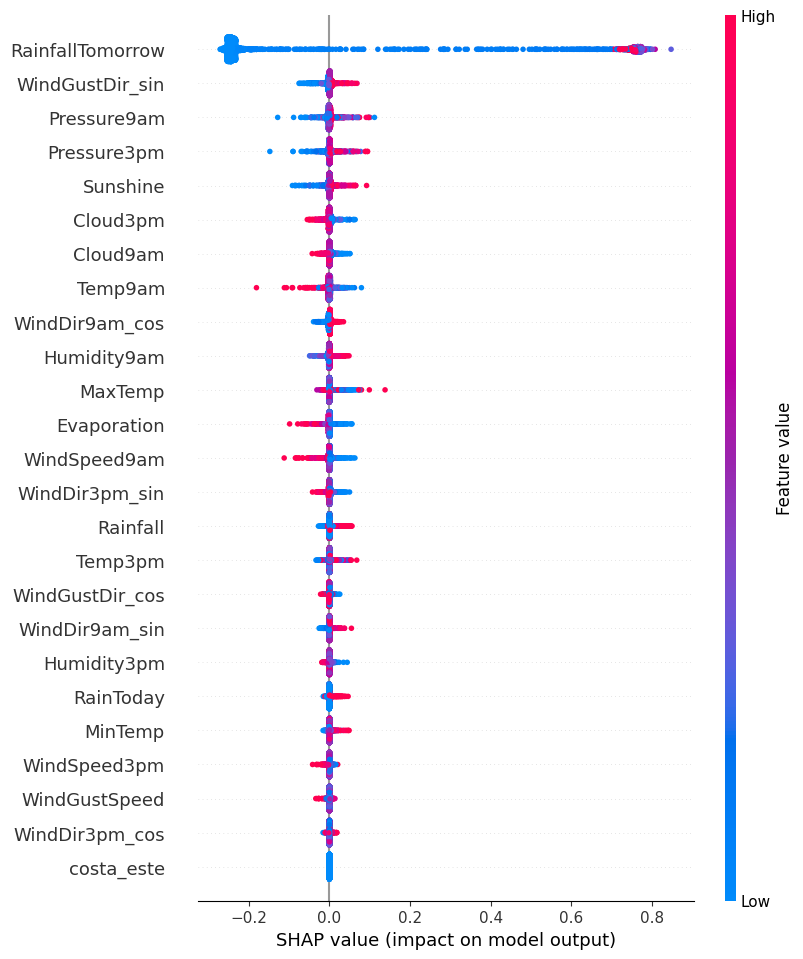

In [32]:
explainer = shap.Explainer(best_model,
                            X_train_regresion.values,
                            feature_names=X_train_regresion.columns)

explanation = explainer(X_test_regresion)

shap.plots.beeswarm(explanation, max_display=None)

In [33]:
x_train_array = X_train_regresion.values
x_test_array = X_test_regresion.values

# Crea el explainer usando DeepExplainer
explainer = shap.DeepExplainer(best_model, x_train_array)

# Obtén las explicaciones para x_test_reg
explanation = explainer.shap_values(x_test_array)


shap.summary_plot(explanation, x_test_array, feature_names=X_train_regresion.columns)

AttributeError: 'tuple' object has no attribute 'as_list'